In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/features_30_sec.csv')

In [3]:
# Identify Features and Target Label
y = data['label']
X = data.drop(columns = ['label','filename','length'])


In [4]:
# Scaling and Data Spiltting  
X = standardize(X)
X_dev, y_dev, X_test, y_test = split(X, y)


X_dev shape: (800, 57)
X_test shape: (200, 57)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [5]:
model_rf = RandomForestClassifier()
model_rf.fit(X_dev, y_dev)
predsDevrf = model_rf.predict(X_dev)
predsTestrf = model_rf.predict(X_test)

In [6]:
testrf_score =  accuracy_score(y_test, predsTestrf)
devrf_score = accuracy_score(y_dev, predsDevrf)

In [7]:
print("Classification Score for Random Forest on Dev dataset:\n")
print("Dev Score : ", devrf_score)
print(classification_report(y_dev, predsDevrf))
print("--------------------------------------------------------")
print("Classification Score for Random Forest on Test dataset:\n")
print("Test Score :", testrf_score)
print(classification_report(y_test, predsTestrf))

Classification Score for Random Forest on Dev dataset:

Dev Score :  0.99875
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00        88
   classical       1.00      1.00      1.00        84
     country       1.00      1.00      1.00        78
       disco       1.00      1.00      1.00        78
      hiphop       1.00      1.00      1.00        81
        jazz       1.00      1.00      1.00        71
       metal       0.99      1.00      0.99        81
         pop       1.00      1.00      1.00        84
      reggae       1.00      1.00      1.00        78
        rock       1.00      0.99      0.99        77

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

--------------------------------------------------------
Classification Score for Random Forest on Test dataset:

Test Score : 0.735
              precision    reca

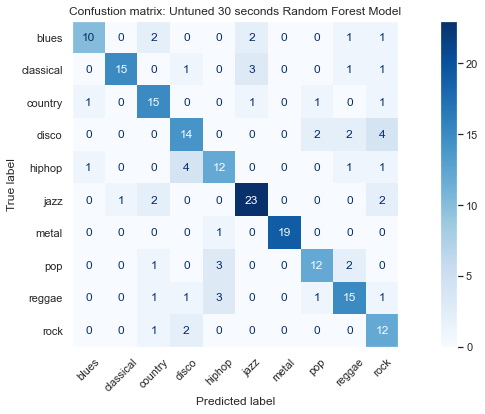

Accuracy : 0.73
Macro F-1 Score : 0.73


In [8]:
# Evaluate Model on Test set
class_labels = list(model_rf.classes_)
macro_f1, accuracy = evaluate_model(predsTestrf, y_test, class_labels, 'Confustion matrix: Untuned 30 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [9]:

parameters = {'min_samples_split': np.linspace(10,100,5,dtype=int),
              'n_estimators': np.linspace(50,200,5,dtype=int),
             'bootstrap': [True]}

print(parameters)

{'min_samples_split': array([ 10,  32,  55,  77, 100]), 'n_estimators': array([ 50,  87, 125, 162, 200]), 'bootstrap': [True]}


In [10]:
tune_rf = GridSearchCV(estimator = model_rf, param_grid = parameters, cv = 5)
tune_rf.fit(X_dev, y_dev)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True],
                         'min_samples_split': array([ 10,  32,  55,  77, 100]),
                         'n_estimators': array([ 50,  87, 125, 162, 200])})

In [11]:
print("Best Score :", tune_rf.best_score_)
print("Best Parameters :",tune_rf.best_params_)

Best Score : 0.6725000000000001
Best Parameters : {'bootstrap': True, 'min_samples_split': 10, 'n_estimators': 87}


In [12]:
predsDevrf_tuned = tune_rf.predict(X_dev)
predsTestrf_tuned = tune_rf.predict(X_test)

print("Score on Dev data for RF using GridSearchCV:", accuracy_score(y_dev, predsDevrf_tuned))
print("Score on Test data for RF using GridSearchCV:",accuracy_score(y_test, predsTestrf_tuned))

Score on Dev data for RF using GridSearchCV: 0.99125
Score on Test data for RF using GridSearchCV: 0.69


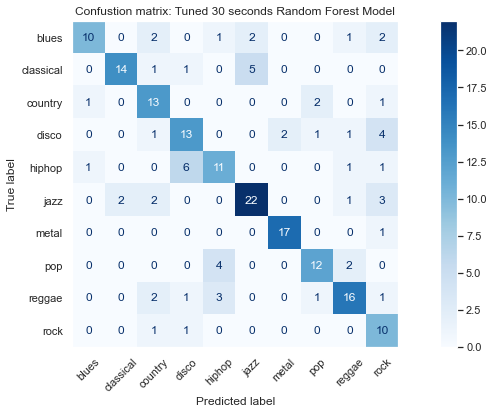

Accuracy : 0.69
Macro F-1 Score : 0.69


In [13]:
# Evaluate Model on Test set
class_labels = list(model_rf.classes_)
macro_f1, accuracy = evaluate_model(predsTestrf_tuned, y_test, class_labels, 'Confustion matrix: Tuned 30 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

In [14]:
## Plot top 3 Important Features of tuned model

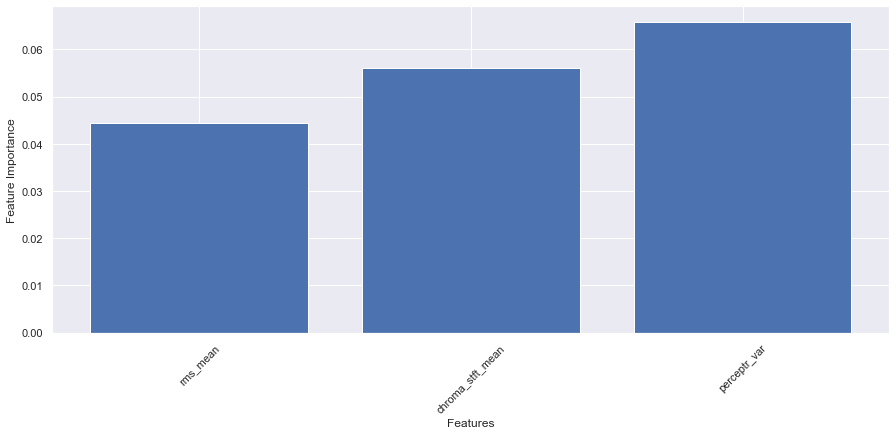

In [15]:
feature_imp_rf = tune_rf.best_estimator_.feature_importances_
final_list_rf = zip(feature_imp_rf,X_dev.columns)
res_rf = sorted(final_list_rf, key = lambda x: x[0])
res_rf = res_rf[-3:]

plt.bar(range(len(res_rf)),[val[0] for val in res_rf],align='center')
plt.xticks(range(len(res_rf)),[val[1] for val in res_rf])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.show()

### Dimensionality reduction of data using PCA

In [16]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.27766419 0.24831461 0.10817539 0.0735775  0.05921353 0.04313114
 0.03041835 0.02485929 0.02357102 0.0185913  0.01458576 0.01445453
 0.01236632 0.01085372 0.01042908 0.00964281 0.00916213 0.00839634
 0.00793393 0.00728809 0.00723328 0.00675799 0.00606166 0.00560817
 0.00551532 0.00512688 0.00504824 0.00465143 0.00453946 0.00423748]
Sum of Explained Variance: 0.9554568006557058


In [17]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099419,-0.209190,-0.328527,0.078996,-0.157331,...,0.038788,-0.015071,0.079879,0.043555,-0.019641,0.030665,0.074443,0.062874,-0.002240,blues
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098223,-0.077306,0.046258,-0.040621,0.094603,...,-0.045994,-0.069099,-0.016187,0.046549,0.036000,0.010682,0.050820,0.013642,-0.016670,rock
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150014,-0.066611,-0.197733,0.041883,0.013269,...,0.035797,0.010193,-0.059763,-0.158196,-0.006597,0.116422,0.030142,0.001622,-0.030251,reggae
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091609,0.131252,-0.044361,0.123934,...,0.002936,-0.002321,-0.015166,0.031948,-0.035315,0.016504,0.000345,0.019162,-0.026266,rock
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025042,-0.233483,0.295023,0.131564,...,-0.081856,0.058812,-0.018336,-0.017691,-0.000411,-0.046398,-0.034568,-0.015858,0.021153,reggae


In [18]:
# from sklearn.preprocessing import OrdinalEncoder
# encoder  = OrdinalEncoder()
# encoder.fit(pca_final.iloc[:,10].reshape(-1, 1))
# y_train_encoded = encoder.transform(pca_final.iloc[:,10])

### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [19]:
model_pca = RandomForestClassifier(max_depth=2,n_estimators=1000)
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainrf = model_pca.predict(pca_data)
pcaTestrf = model_pca.predict(pca_data_test)

In [20]:
pcatestrf_score =  accuracy_score(y_test, pcaTestrf)
pcarf_score = accuracy_score(y_dev, pcaTrainrf)

In [21]:
print("Classification Score for Random Forest on Train dataset:\n")
print("Train Score : ", pcarf_score)
print("--------------------------------------------------------")
print("Classification Score for Random Forest on Test dataset:\n")
print("Test Score :", pcatestrf_score)

Classification Score for Random Forest on Train dataset:

Train Score :  0.5575
--------------------------------------------------------
Classification Score for Random Forest on Test dataset:

Test Score : 0.4


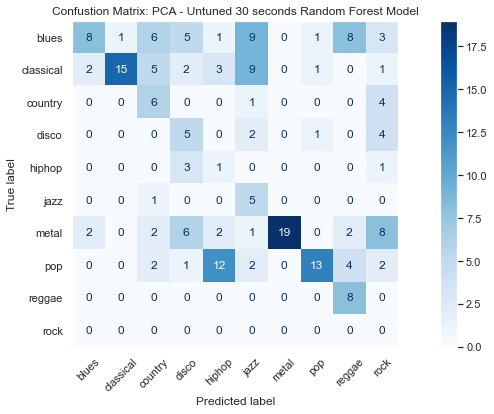

Accuracy : 0.40
Macro F-1 Score : 0.35


In [22]:
# Evaluate Model
class_labels = list(model_rf.classes_)
macro_f1, accuracy = evaluate_model(pcaTestrf, y_test, class_labels, 'Confustion Matrix: PCA - Untuned 30 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [23]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099419,-0.209190,-0.328527,0.078996,-0.157331,...,0.041511,0.038788,-0.015071,0.079879,0.043555,-0.019641,0.030665,0.074443,0.062874,-0.002240
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098223,-0.077306,0.046258,-0.040621,0.094603,...,-0.041874,-0.045994,-0.069099,-0.016187,0.046549,0.036000,0.010682,0.050820,0.013642,-0.016670
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150014,-0.066611,-0.197733,0.041883,0.013269,...,0.088440,0.035797,0.010193,-0.059763,-0.158196,-0.006597,0.116422,0.030142,0.001622,-0.030251
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091609,0.131252,-0.044361,0.123934,...,-0.015720,0.002936,-0.002321,-0.015166,0.031948,-0.035315,0.016504,0.000345,0.019162,-0.026266
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025042,-0.233483,0.295023,0.131564,...,0.016496,-0.081856,0.058812,-0.018336,-0.017691,-0.000411,-0.046398,-0.034568,-0.015858,0.021153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.565572,0.422083,0.328459,0.111136,-0.153392,-0.133144,0.121273,0.170827,0.181533,-0.003556,...,0.293726,-0.012901,0.057803,0.047347,0.082716,-0.066850,0.015040,-0.025102,-0.002081,0.007022
796,0.258810,-0.934083,0.031836,0.495334,0.077337,-0.114135,0.171023,-0.128285,0.103759,0.171803,...,0.029218,-0.007028,-0.041560,0.057839,0.158472,0.041057,-0.134016,-0.031571,0.099226,0.002889
797,1.243638,0.799851,0.648936,0.304699,-0.379732,0.291342,-0.171433,-0.020330,0.029576,-0.338972,...,-0.005376,-0.006001,0.013803,-0.004586,0.053536,-0.001094,-0.064922,-0.096570,-0.039828,0.010509
798,0.251711,0.398993,-0.418890,-0.045822,0.030828,0.140385,-0.063130,-0.085621,-0.096350,0.127769,...,0.080084,-0.049147,0.017611,-0.004224,-0.024661,0.124116,-0.097227,-0.054099,0.028042,-0.099130


In [24]:
model_pca_tuned = tune_rf
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainrf_tuned = model_pca_tuned.predict(pca_data)
pcaTestrf_tuned = model_pca_tuned.predict(pca_data_test)

In [25]:
pcatestrf_score =  accuracy_score(y_test, pcaTestrf)
pcarf_score = accuracy_score(y_dev, pcaTrainrf)

In [26]:
print("Classification Score for Random Forest on Train dataset:\n")
print("Train Score : ", pcarf_score)
print("--------------------------------------------------------")
print("Classification Score for Random Forest on Test dataset:\n")
print("Test Score :", pcatestrf_score)

Classification Score for Random Forest on Train dataset:

Train Score :  0.5575
--------------------------------------------------------
Classification Score for Random Forest on Test dataset:

Test Score : 0.4


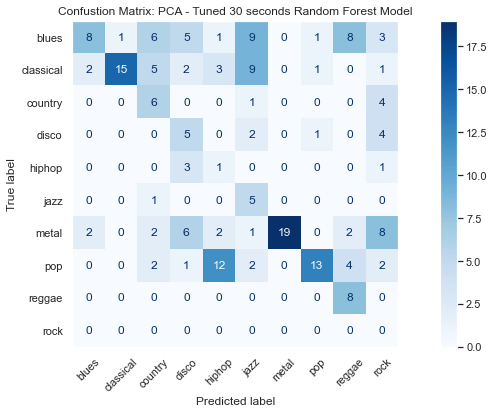

Accuracy : 0.40
Macro F-1 Score : 0.35


In [27]:
# Evaluate Model
class_labels = list(model_rf.classes_)
macro_f1, accuracy = evaluate_model(pcaTestrf, y_test, class_labels, 'Confustion Matrix: PCA - Tuned 30 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

**Ans:** As we see due to the lesser number of data, PCA instead of helping in the improvement of the accuracy or the model learning by reducing the dimensions ("the curse of dimensionality"), makes the model worse. 